In [1]:
import glob
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import mdshare
import pyemma
from tqdm.notebook import tqdm
from matplotlib import rc
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
#from scipy.stats import gaussian_kde

import seaborn as sns


In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["computer modern roman"],
    "font.size": 12})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

nn=np.linspace(-1,3)

##  Functions

In [3]:
def get_histogram(
        xall, yall, nbins=100,
        weights=None, avoid_zero_count=False):
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins=nbins, weights=weights)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    if avoid_zero_count:
        z = _np.maximum(z, _np.min(z[z.nonzero()]))
    return x, y, z.T # transpose to match x/y-directions

def _to_density(z):
    return z / float(z.sum())

def _to_free_energy(z, minener_zero=False):
    pi = _to_density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])
    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

def plot_map(
        x, y, z, ax=None, cmap=None,
        ncontours=100, vmin=None, vmax=None, levels=None,
        cbar=True, cax=None, cbar_label=None,
        cbar_orientation='vertical', norm=None,
        **kwargs):

    import matplotlib.pyplot as _plt
    if ax is None:
        fig, ax = _plt.subplots()
    else:
        fig = ax.get_figure()
    mappable = ax.contourf(
        x, y, z, ncontours, norm=norm,
        vmin=vmin, vmax=vmax, cmap=cmap,
        levels=levels)
    misc = dict(mappable=mappable)
    if cbar_orientation not in ('horizontal', 'vertical'):
        raise ValueError(
            'cbar_orientation must be "horizontal" or "vertical"')
    if cbar:
        if cax is None:
            cbar_ = fig.colorbar(
                mappable, ax=ax, orientation=cbar_orientation)
        else:
            cbar_ = fig.colorbar(
                mappable, cax=cax, orientation=cbar_orientation)
        if cbar_label is not None:
            cbar_.set_label(cbar_label)
        misc.update(cbar=cbar_)
    return fig, ax, misc

# Load Data

In [4]:
data = []
lendata = []

#Loop through the directories containing the paths
for directory in glob.glob("./run*",recursive=True):
    print("Directory",directory)
    #Loop through the paths
    pathname=directory+"/CVscreeningeneptm.dat"
    print(directory,pathname)
    for file in glob.glob(pathname):      
        inp = np.loadtxt(file, skiprows=2,usecols=np.arange(0,18))
        data.append(inp)
        lendata.append(len(inp))

# Data concatenated
Data = np.concatenate(data)
Data = np.delete(Data,0,1)

numCVs = Data.shape[1]
datalabels = ["cn.mean","ncl","ncs","Q4.mean","q4.mean","ncnq4","laQ4.mean","Q6.mean","q6.mean","ncnq6","laQ6.mean","ent","nclust1", "ene", "non", "fcc", "hcp"]
npdatalabels = np.array(["cn.mean","ncl","ncs","Q4.mean","q4.mean","ncnq4","laQ4.mean","Q6.mean","q6.mean","ncnq6","laQ6.mean","ent","nclust1", "ene", "non", "fcc", "hcp"])


Directory ./run38N
./run38N ./run38N/CVscreeningeneptm.dat
Directory ./run39Y
./run39Y ./run39Y/CVscreeningeneptm.dat
Directory ./run99Y
./run99Y ./run99Y/CVscreeningeneptm.dat
Directory ./run612N
./run612N ./run612N/CVscreeningeneptm.dat
Directory ./run525Y
./run525Y ./run525Y/CVscreeningeneptm.dat
Directory ./run725N
./run725N ./run725N/CVscreeningeneptm.dat
Directory ./run733Y
./run733Y ./run733Y/CVscreeningeneptm.dat
Directory ./run17N
./run17N ./run17N/CVscreeningeneptm.dat
Directory ./run178Y
./run178Y ./run178Y/CVscreeningeneptm.dat
Directory ./run1003new
./run1003new ./run1003new/CVscreeningeneptm.dat
Directory ./run1004new
./run1004new ./run1004new/CVscreeningeneptm.dat
Directory ./run1001new
./run1001new ./run1001new/CVscreeningeneptm.dat
Directory ./run287Y
./run287Y ./run287Y/CVscreeningeneptm.dat
Directory ./run1000new
./run1000new ./run1000new/CVscreeningeneptm.dat
Directory ./run1002new
./run1002new ./run1002new/CVscreeningeneptm.dat


### Plot the time series

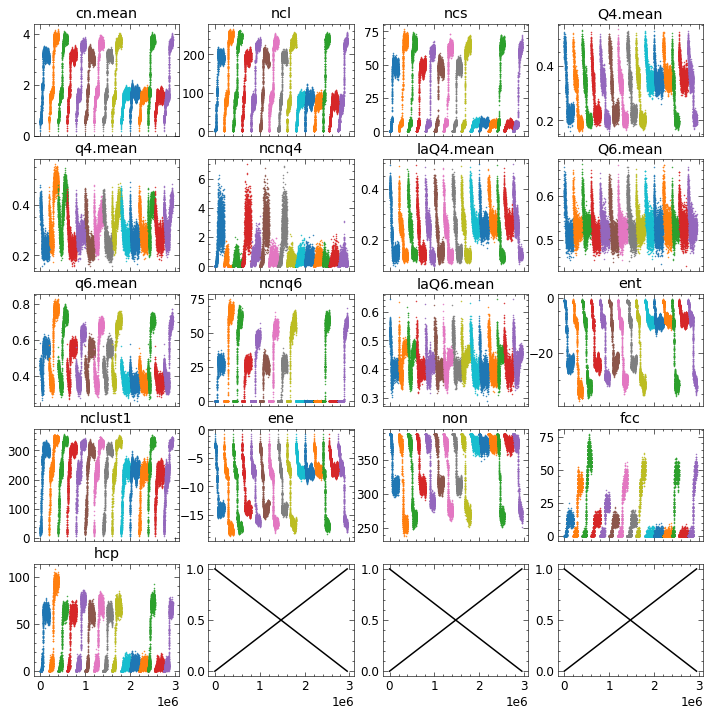

In [5]:
panels = int(np.sqrt(numCVs))+1
figure, axis = plt.subplots(panels, panels-1, figsize=(12,12), sharex=True)

cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C1']
c = 0
xax = np.arange(0,Data.shape[0])

for i in range(0,panels):
    for j in range(0,panels-1):           
        
        if c < numCVs:
            tf = 0
                
            for traj in range(0,len(lendata)):
                t0 = tf
                tf += lendata[traj]
                #print(c,traj, lendata[traj],t0,tf)

                axis[i, j].plot(xax[t0:tf:100],Data[t0:tf:100,c],'o',markersize=0.5)
                axis[i, j].set_title(format(datalabels[c]))              

        else:
            axis[i, j].plot([0,Data.shape[0]],[1,0],'k-')
            axis[i, j].plot([0,Data.shape[0]],[0,1],'k-')
                                     
        c += 1

#plt.show()
#figure.savefig('./CVsTimeseries.png', dpi=300, bbox_inches='tight')

### Select the RC

In [6]:
# The BEST reaction coordinates:
RC = np.full((numCVs, numCVs), 100, dtype=int)

RC[0,0]     = 2
RC[1,0:2]   = [2, 9]
RC[2,0:3]   = [2, 9, 12]
RC[3,0:4]   = [2, 9, 12, 15]
RC[4,0:5]   = [2, 9, 11, 13, 15]
RC[5,0:6]   = [1, 2, 9, 11, 12, 15]
RC[6,0:7]   = [1, 2, 4, 9, 11, 12, 15]
RC[7,0:8]   = [1, 2, 4, 6, 9, 11, 12, 15]
RC[8,0:9]   = [1, 2, 4, 6, 9, 11, 12, 13, 15]
RC[9,0:10]  = [1, 2, 4, 6, 9, 11, 12, 13, 15, 16]
RC[10,0:11] = [1, 2, 4, 5, 6, 9, 11, 12, 13, 15, 16]
RC[11,0:12] = [1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16]
RC[12,0:13] = [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16]
RC[13,0:14] = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16]
RC[14,0:15] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16]
RC[15,0:16] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16]
RC[16,0:17] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [7]:
CVdim = 17
RC_CVs = RC[CVdim-1,0:CVdim]
Data[:,RC_CVs].shape
npdatalabels[RC_CVs].tolist()

['cn.mean',
 'ncl',
 'ncs',
 'Q4.mean',
 'q4.mean',
 'ncnq4',
 'laQ4.mean',
 'Q6.mean',
 'q6.mean',
 'ncnq6',
 'laQ6.mean',
 'ent',
 'nclust1',
 'ene',
 'non',
 'fcc',
 'hcp']

### Plot Feature Histogram

In [8]:
DataNorm = np.zeros(Data[:,RC_CVs].shape)
for i in range(0,DataNorm.shape[1]):
    print(datalabels[RC_CVs[i]],np.amin(Data[:,RC_CVs[i]]),np.amax(Data[:,RC_CVs[i]]))
    DataNorm[:,i] = np.abs(Data[:,RC_CVs[i]])/np.amax(np.abs(Data[:,RC_CVs[i]]))


cn.mean 0.142608 4.209561
ncl 0.0022 267.382347
ncs 3.4e-05 76.965064
Q4.mean 0.153038 0.564744
q4.mean 0.143395 0.576264
ncnq4 0.0 9.238967
laQ4.mean 0.092013 0.502845
Q6.mean 0.404036 0.712979
q6.mean 0.253202 0.849934
ncnq6 1.3e-05 75.38844
laQ6.mean 0.287928 0.644605
ent -37.697048 -0.39205
nclust1 5.0 357.0
ene -18.919509 -0.67177002
non 234.0 388.0
fcc 0.0 78.0
hcp 0.0 111.0


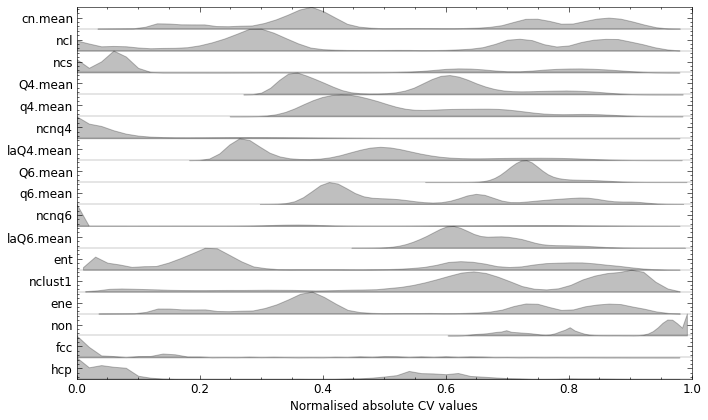

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
pyemma.plots.plot_feature_histograms(DataNorm,feature_labels=npdatalabels[RC_CVs[:]].tolist(),ax=ax,color='black');
ax.set_xlim(0,1)
ax.set_xlabel('Normalised absolute CV values')
fig.tight_layout()
#plt.savefig('./CVdistnorm.png', dpi=300, bbox_inches='tight')

# Do TICA 

In [10]:
from deeptime.decomposition import TICA
from deeptime.decomposition import VAMP

lagt= 50
#tica_estimator = TICA(dim=2, lagtime=lagt).fit(DataNorm)
tica_estimator = VAMP(dim=2, lagtime=lagt).fit(DataNorm)
tica = tica_estimator.fetch_model()
tics = tica.transform(DataNorm)

<Figure size 288x144 with 0 Axes>

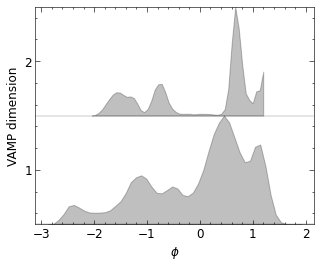

In [11]:
plt.figure(figsize=(4, 2))
pyemma.plots.plot_feature_histograms(tics, color='k')
plt.xlabel(r'$\phi$')
plt.ylabel('VAMP dimension')
plt.yticks(ticks=[0.3,1.3], labels=['1', '2'])
plt.savefig('./tics_features.png', dpi=300, bbox_inches='tight')

<Figure size 288x288 with 0 Axes>

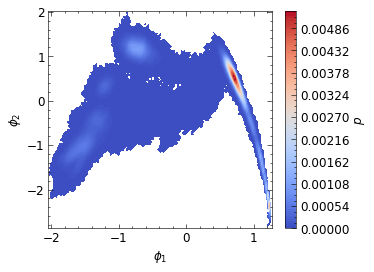

In [12]:
plt.figure(figsize=(4, 4))
pyemma.plots.plot_density(tics[:,0],tics[:,1],cmap='coolwarm',nbins=150,cbar_label='$p$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
plt.xlabel(r'$\phi_1$') 
plt.ylabel(r'$\phi_2$')
plt.savefig('./CVS_tics_dens.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, '$\\phi_2$')

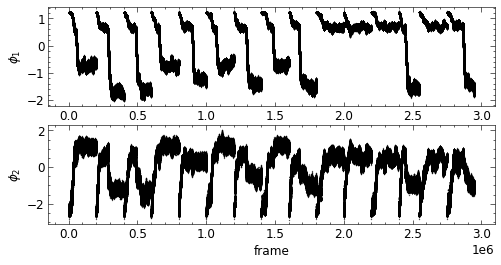

In [13]:
fig, ax = plt.subplots(2, figsize=(8, 4))
ax[0].plot(tics[:,0],'k.',markersize=pms/5)
ax[0].set_xlabel('frame')
ax[0].set_ylabel(r'$\phi_1$')
ax[1].plot(tics[:,1],'k.',markersize=pms/5)
ax[1].set_xlabel('frame')
ax[1].set_ylabel(r'$\phi_2$')

### Check the mapping of states from what we know

Text(0, 0.5, '$\\phi_2$')

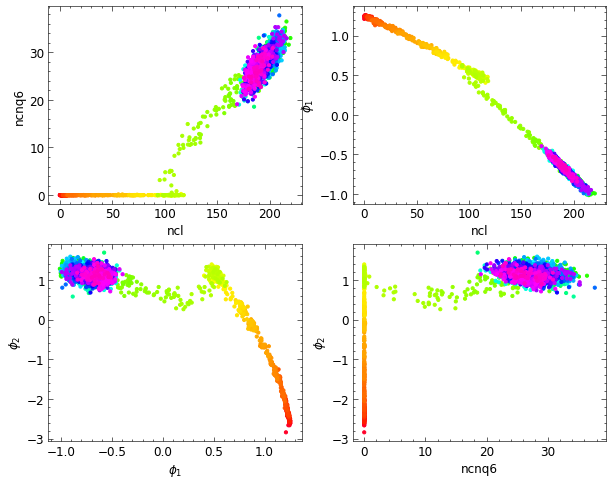

In [14]:
fig, ax = plt.subplots(2,2, figsize=(10, 8))

t0 = 0
tf = 200000
cols = np.arange(0,2000)/2000

ax[0,0].scatter(Data[t0:tf:100,1],Data[t0:tf:100,9],s=10,c=cols,cmap='gist_rainbow')
ax[0,0].set_xlabel('ncl')
ax[0,0].set_ylabel('ncnq6')

ax[1,0].scatter(tics[t0:tf:100,0],tics[t0:tf:100,1],s=10,c=cols,cmap='gist_rainbow')
ax[1,0].set_xlabel(r'$\phi_1$')
ax[1,0].set_ylabel(r'$\phi_2$')

ax[0,1].scatter(Data[t0:tf:100,1],tics[t0:tf:100,0],s=10,c=cols,cmap='gist_rainbow')
ax[0,1].set_xlabel('ncl')
ax[0,1].set_ylabel(r'$\phi_1$')

ax[1,1].scatter(Data[t0:tf:100,9],tics[t0:tf:100,1],s=10,c=cols,cmap='gist_rainbow')
ax[1,1].set_xlabel('ncnq6')
ax[1,1].set_ylabel(r'$\phi_2$')

### Discretise the TICA space

In [15]:
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace

#estimator = KMeans(100, init_strategy='uniform', max_iter=100, progress=tqdm).fit(tics).fetch_model()
#estimator = RegularSpace(dmin=0.15,max_centers=100,n_jobs=4).fit(DataConc).fetch_model()
estimator = RegularSpace(dmin=0.15,max_centers=500).fit(tics).fetch_model()

dtraj = estimator.transform(tics)
print("Number of states:",estimator.cluster_centers.shape[0])

Number of states: 238


<Figure size 288x288 with 0 Axes>

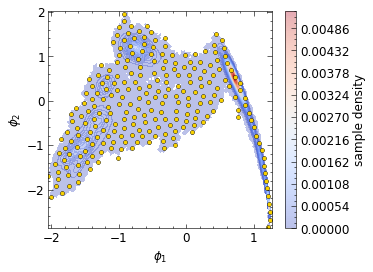

In [16]:
plt.figure(figsize=(4, 4))
pyemma.plots.plot_density(tics[:,0],tics[:,1],cbar=True, alpha=0.35,cmap='coolwarm',nbins=150)
plt.scatter(*estimator.cluster_centers.T, s=12, c='black')
plt.scatter(*estimator.cluster_centers.T, s=8, c='gold')
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')

plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
plt.savefig('./CVScluster_features.png', dpi=300, bbox_inches='tight')

### Plot the TICA trajectory

Text(0, 0.5, 'partition')

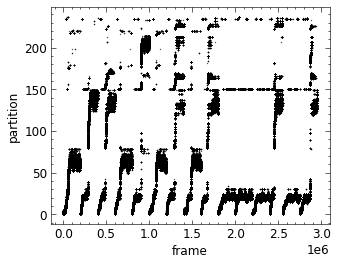

In [17]:
plt.plot(dtraj,'k.',markersize=pms/5)
plt.xlabel('frame')
plt.ylabel('partition')

Text(0, 0.5, 'partition')

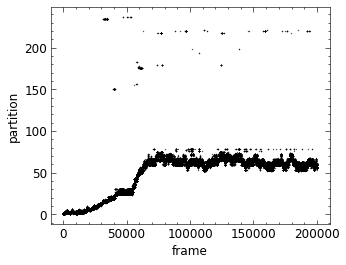

In [18]:
plt.plot(dtraj[0:200000],'k.',markersize=pms/5)
plt.xlabel('frame')
plt.ylabel('partition')

### Calculate the TICA VAMP-2 score

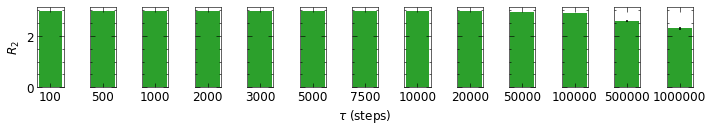

In [19]:
from deeptime.decomposition import vamp_score_cv

lags = [1,5,10,20,30,50,75,100, 200, 500, 1000, 5000, 10000] 
fig, axes = plt.subplots(1, 13, figsize=(10, 2), sharey=True)
labels = ['TICA']

for ax, lag in zip(axes.flat, lags):
    tica_estimator.lagtime = lag
    scores = vamp_score_cv(tica_estimator, trajs=tics, blocksplit=True, blocksize=10000)
    means = [scores.mean()]
    errors = [scores.std()]
    ax.bar('{}'.format(lag*100), means, yerr=errors, color='C2')
    
    #ax.bar(lag, means, yerr=errors, color=['C2', 'C3', 'C4'])
    #ax.set_title(r'$\tau$={}'.format(lag))

#plt.xticks(rotation=30, ha='right')
axes[0].set_ylabel(r'$R_2$')
axes[6].set_xlabel(r'$\tau$ (steps)')
fig.tight_layout()
plt.savefig('ticavamp2.png', dpi=300, bbox_inches='tight')

### Build a Max Liklihood MSM - deeptime

  0%|          | 0/13 [00:00<?, ?it/s]

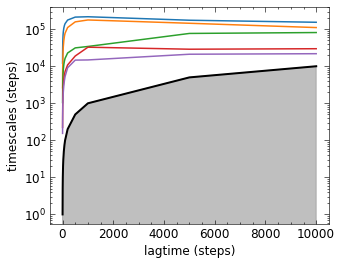

In [20]:
from deeptime.markov.msm import BayesianMSM
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

models = []
for lag in tqdm(lags, leave=False):
    #models.append(BayesianMSM(lagtime=lag).fit_fetch(dtraj)) # NOT WORKING!!!!
    models.append(MaximumLikelihoodMSM(lagtime=lag).fit_fetch(dtraj))    

its = implied_timescales(models)
#its = its_bayesian_msm(dtraj, [1000])

ax = plot_implied_timescales(its, n_its=5)
ax.set_yscale('log')
ax.set_xlabel('lagtime (steps)')
ax.set_ylabel('timescales (steps)');



### Build a Bayesian MSM - PyEMMA

In [21]:
its = pyemma.msm.its(dtraj, lags=lags, nits=5, errors='bayes')

estimating BayesianMSM:   0%|                                                                                 …

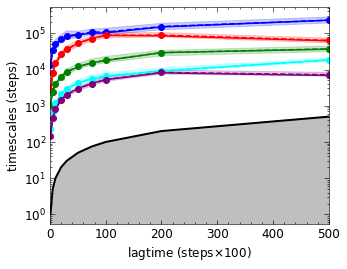

In [22]:
plt.figure(figsize=(5, 4))
pyemma.plots.plot_implied_timescales(its, ylog=True);
plt.xlabel(r'lagtime (steps$\times 100$)')
plt.ylabel('timescales (steps)');
plt.xlim(0,500)
plt.savefig('ticaBayesMSM.png', dpi=300, bbox_inches='tight')

In [23]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtraj, lag=lagt, conf=0.95, count_mode='effective', dt_traj='10 ps',mincount_connectivity=1E-5)
sample_mean = bayesian_msm.sample_mean('timescales', k=1)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=1)

print('Mean of first ITS: {:f}'.format(sample_mean[0]))
print('Confidence interval: [{:f}, {:f}]'.format(sample_conf_l[0], sample_conf_r[0]))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[2]: compute stat. inefficiencies:   0%|                        …

pyemma.msm.estimators.bayesian_msm.BayesianMSM[2]: Sampling MSMs:   0%|                                       …

Mean of first ITS: 941410.711587
Confidence interval: [762715.542033, 1217350.514096]


### Check the states are all being used

In [24]:
from deeptime.markov import TransitionCountEstimator

counts_estimator = TransitionCountEstimator(lagtime=lagt, count_mode='sliding')
counts = counts_estimator.fit_fetch(dtraj).submodel_largest()

msm_estimator = MaximumLikelihoodMSM()
msm = msm_estimator.fit_fetch(counts)

print(f'fraction of states used = {msm.state_fraction}')
print(f'fraction of counts used = {msm.count_fraction}')
msm.timescales(k=4)

fraction of states used = 1.0
fraction of counts used = 1.0


array([107062.0610555 ,  48925.49603389,  11068.35618639,   4382.61020051])

### C-K test

/home/aaron/Packages/anaconda3/envs/workshop/lib/python3.9/site-packages/deeptime/plots/chapman_kolmogorov.py:173: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


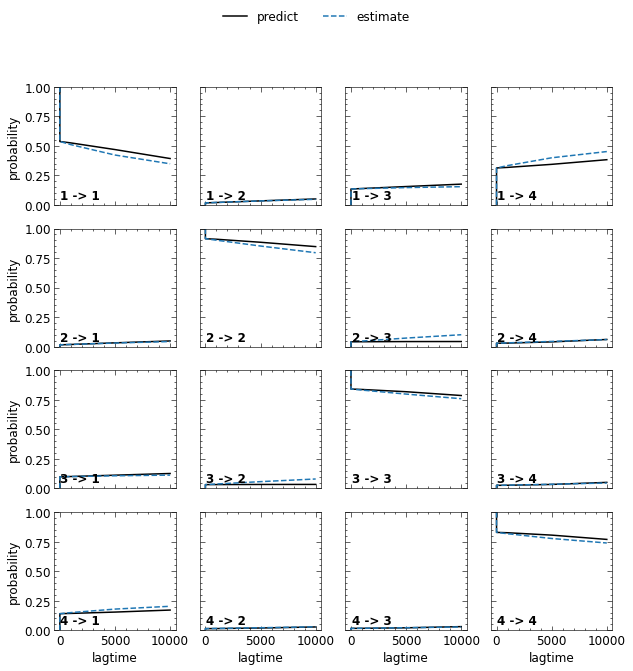

In [25]:
from deeptime.plots import plot_ck_test
ck_test = msm.ck_test(models, n_metastable_sets=4)
plot_ck_test(ck_test, xlabel='lagtime', sharey=True);
plt.savefig('ticaCK.png', dpi=300, bbox_inches='tight')

### Stationary distribution

<Figure size 288x288 with 0 Axes>

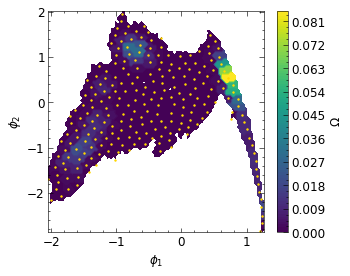

In [26]:
plt.figure(figsize=(4, 4))
fig, ax, misc = pyemma.plots.plot_contour(
    *tics.T, msm.stationary_distribution[dtraj],
    cbar_label='$\Omega$',
    method='nearest', mask=True)
ax.scatter(*estimator.cluster_centers.T, s=2, c='gold')
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
#ax.set_aspect('equal')
fig.set_figheight(4)
fig.set_figwidth(5)
fig.tight_layout()
plt.savefig('ticaStationary.png', dpi=300, bbox_inches='tight')



### Free Energy

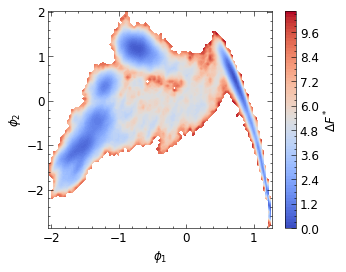

In [27]:

fig, ax, misc = pyemma.plots.plot_free_energy(
    *tics.T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    legacy=False,
    nbins=100,
    #cmap='viridis',
    cbar_label='$\Delta F^*$',
    minener_zero=True,
    cmap='coolwarm')

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
fig.set_figheight(4)
fig.set_figwidth(5)
plt.savefig('ticaFE.png', dpi=300, bbox_inches='tight')

0 (83, 69) 0.7172137768140208 0.5288405928579694 0.0
1 (99, 8) 1.2464562104114107 -2.4564340236576268 0.2504374970409282
2 (40, 82) -0.7051252634789662 1.1650466586727686 0.302926366495341
3 (15, 37) -1.5320665659748887 -1.0372051076092283 0.6826017638047981
4 (86, 60) 0.8164467331135312 0.08839023960156989 0.7525815094978991


Text(0, 0.5, '$\\phi_2$')

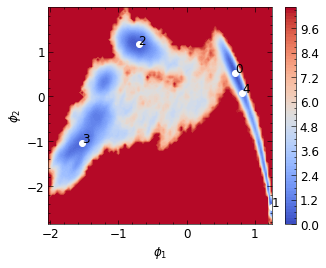

In [28]:
# Probability density
x, y, z = get_histogram(
    *tics.T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    nbins=100,
    )

# Free energy
kT = 1.
f = _to_free_energy(z, minener_zero=True) * kT

fmax = np.amax(f[f != np.inf])
f[f == np.inf] = fmax # replace inf

# Plot
plot_map(x, y, f,
         cmap='coolwarm',
         ncontours=100,
         cbar=True,
         cbar_orientation='vertical')

xyc = 8
minxy = []
for i in range(0,5):
    # Get the minimum FE
    pmin = np.unravel_index(f.T.argmin(), f.T.shape)

    plt.plot(x[pmin[0]],y[pmin[1]],'ow')
    plt.text(x[pmin[0]],y[pmin[1]],i)
    print(i,pmin,x[pmin[0]],y[pmin[1]],f.T[pmin])
    minxy.append([x[pmin[0]],y[pmin[1]]])
    
    # Remove this point
    f.T[pmin[0]-xyc:pmin[0]+xyc,pmin[1]-xyc:pmin[1]+xyc] = 100
    
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')


### Comittor Analysis

In [29]:
posA = np.array(minxy[0])
posB = np.array(minxy[1])

A = [np.argmin(np.sum(np.abs(estimator.cluster_centers-posA),axis=1))]
B = [np.argmin(np.sum(np.abs(estimator.cluster_centers-posB),axis=1))]

<Figure size 288x288 with 0 Axes>

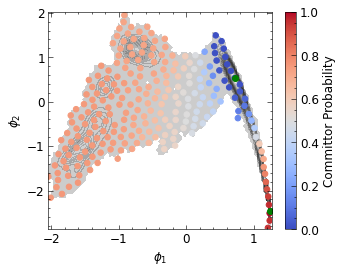

In [30]:
plt.figure(figsize=(4, 4))
tpt = pyemma.msm.tpt(bayesian_msm, A, B)
fig, ax = plt.subplots()
pyemma.plots.plot_density(*tics.T, ax=ax, cbar=False, alpha=0.2, cmap='gray');
sc=ax.scatter(estimator.cluster_centers.T[0,bayesian_msm.active_set],estimator.cluster_centers.T[1,bayesian_msm.active_set], s=30, c=tpt.committor, cmap='coolwarm');
plt.colorbar(sc,label='Committor Probability')
ax.set_xlabel(r'$\phi_1$');
ax.set_ylabel(r'$\phi_2$');
plt.plot(posA[0],posA[1],'og')
plt.plot(posB[0],posB[1],'og')
plt.xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
plt.ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
plt.savefig('Committor-probabilities.png', dpi=300, bbox_inches='tight')

### Eigenvector Analysis

In [31]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: True (min=0.9999999999991588, max=1.0000000000004865)


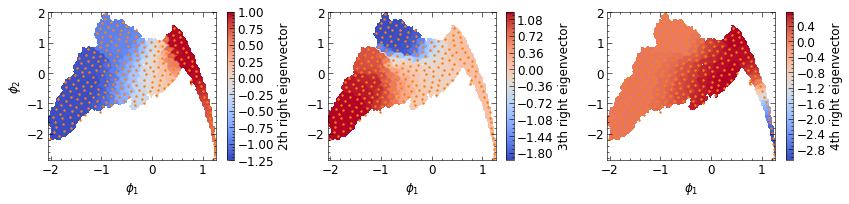

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tics.T, eigvec[dtraj, i + 1], ax=ax, cmap='coolwarm',
        cbar_label='{}th right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*estimator.cluster_centers.T, s=2, c='C1')
    ax.set_xlabel(r'$\phi_1$')
    ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
    ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
    #ax.set_aspect('equal')
axes[0].set_ylabel(r'$\phi_2$')
fig.tight_layout()
plt.savefig('ticavEigenV.png', dpi=300, bbox_inches='tight')

### PCCA

In [33]:
from deeptime.markov import pcca
nstates = 5
pcca = pcca(bayesian_msm.transition_matrix, nstates)

IndexError: index 5 is out of bounds for axis 0 with size 5

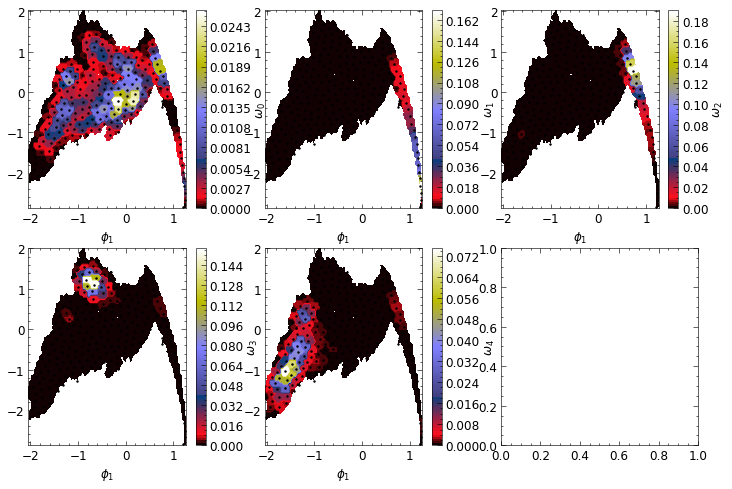

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tics.T, pcca.metastable_distributions[i][dtraj], ax=ax, cmap='gist_stern', 
        mask=True, method='nearest', cbar_label='$\omega_{}$'.format(i))
    ax.scatter(*estimator.cluster_centers.T, s=2, c='k')
    ax.set_xlabel(r'$\phi_1$')
    ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]));
    ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]));
    #ax.set_aspect('equal')
axes[0].set_ylabel(r'$\phi_2$')
fig.tight_layout()
plt.savefig('ticaMetastableD.png', dpi=300, bbox_inches='tight')

In [35]:
for i, s in enumerate(pcca.sets):
    print('π_{} = {:f}'.format(i, msm.stationary_distribution[s].sum()))

π_0 = 0.017220
π_1 = 0.112257
π_2 = 0.426761
π_3 = 0.180026
π_4 = 0.263736


#### MFPT from PCCA

In [36]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            pcca.sets[i],
            pcca.sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=0), index=range(0, nstates), columns=range(0, nstates))

MFPT / steps:


,0,1,2,3,4
0,0.0,129447.0,82968.0,134999.0,124902.0
1,184263.0,0.0,34556.0,259537.0,249145.0
2,171463.0,48617.0,0.0,277527.0,277604.0
3,150273.0,185793.0,182027.0,0.0,130000.0
4,164543.0,193463.0,198391.0,172555.0,0.0


#### PCCA timescales

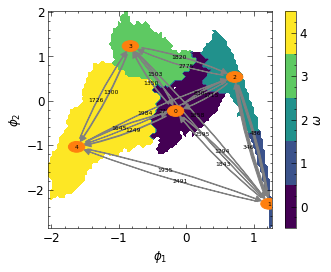

In [37]:
metastable_traj = pcca.assignments[dtraj]
highest_membership = pcca.metastable_distributions.argmax(1)
coarse_state_centers = estimator.cluster_centers[msm.count_model.state_symbols[highest_membership]]


inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(*tics.T, metastable_traj, ax=ax, zorder=-1)
misc['cbar'].set_ticklabels(range(0, nstates))  # set state numbers 1 ... nstates
misc['cbar'].set_label(r'$\omega$')

pyemma.plots.plot_network(
    inverse_mfpt,
    state_scale=0.1,
    state_colors='C1',
    pos=coarse_state_centers,
    #figpadding=0.2,
    arrow_label_format='%.0f',
    arrow_labels=mfpt/100,
    arrow_scale=0.5,
    arrow_curvature=0.5,
    size=6,
    xticks=True,
    yticks=True,
    show_frame=True,
    ax=ax)

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_xlim(np.amin(tics[:,0]),np.amax(tics[:,0]))
ax.set_ylim(np.amin(tics[:,1]),np.amax(tics[:,1]))
#fig.tight_layout()
plt.savefig('pcca.png', dpi=300, bbox_inches='tight')